<a href="https://colab.research.google.com/github/dh610/ai-intensive2/blob/main/lab3/lab3_Word%20Embedding_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ai-intensive2
!git pull
%cd lab3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ai-intensive2
Already up to date.
/content/drive/MyDrive/ai-intensive2/lab3


# Lab 3 : Word Embeddings

@copyright:
    (c) 2023. iKnow Lab. Ajou Univ., All rights reserved.

M.S. Student: Wansik-Jo (jws5327@ajou.ac.kr)

# For assignment

- Python code의 주석 처리되어있는 부분을 구현하면 됩니다.
- MD 형식의 Cell의 [BLANK] 부분을 채우면 됩니다.
- MD 형식의 Cell의 [ANSWER] 부분 이후에 답을 작성하면 됩니다.
- 조교에게 퀴즈의 답과 함께 코드 실행 결과를 보여준 뒤, BB에 제출 후 가시면 됩니다.

---


## 목차

1. Word Embeddings (Introduction)
    - Word2vec
    - Predict Capital of Country
    - PCA
2. CBOW vs Skip-gram
    - CBOW
    - Implementation from Scratch
    - Skip-gram

## 1. Word Embeddings (Introduction)

### 1.1 google word2vec

- word2vec은 2013년 구글 연구팀이 발표한 논문으로, 단어를 벡터로 표현하는 방법론이다.
- word2vec은 CBOW와 Skip-gram 두 가지 방법론을 제시한다.

- [CBOW]는 주변 단어들을 이용해 중심 단어를 예측하는 방법론이다.
- [Skip-gram]은 중심 단어를 이용해 주변 단어들을 예측하는 방법론이다.

해당 실습에서는, 학습된 word2vec 모델을 이용해 word vector를 얻어보고, 이를 이용해 단어 간 관계를 분석한다.

<details>
<summary>Reference</summary>

Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean. Efficient Estimation of Word Representations in Vector Space. In Proceedings of Workshop at ICLR, 2013.

Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado, and Jeffrey Dean. Distributed Representations of Words and Phrases and their Compositionality. In Proceedings of NIPS, 2013.

Tomas Mikolov, Wen-tau Yih, and Geoffrey Zweig. Linguistic Regularities in Continuous Space Word Representations. In Proceedings of NAACL HLT, 2013.
</details>


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv('./data/capital_list.txt', delimiter=' ')
data.columns = ['capital_s', 'country_s', 'capital_t', 'country_t']

data.head()

,capital_s,country_s,capital_t,country_t
0,Athens,Greece,Bangkok,Thailand
1,Athens,Greece,Beijing,China
2,Athens,Greece,Berlin,Germany
3,Athens,Greece,Bern,Switzerland
4,Athens,Greece,Cairo,Egypt


본 실습에서는, [google word2vec](https://code.google.com/archive/p/word2vec/) model을 이용한다.
하지만, [The Original GoogleNews-vectors-negative300.bin.gz](https://code.google.com/archive/p/word2vec/).는 3.64GB로 용량이 매우 크기 때문에, 본 실습을 위하여 사용되는 몇 개의 단어에 대한 word vector만을 추출하여 사용한다.

해당 추출 과정은 다음과 같은 과정으로 추출하여 제공하였다.

<details>
<summary>CODE 보기</summary>

```python
import nltk
from gensim.models import KeyedVectors

embeddings = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary = True)

f = open('capitals.txt', 'r').read()
set_words = set(nltk.word_tokenize(f))
assign_word = words = ['king', 'queen', 'oil', 'gas', 'happy', 'sad', 'city', 'town', 'village', 'country', 'continent', 'petroleum', 'joyful']

for w in assign_word:
    set_words.add(w)

def get_word_embeddings(embeddings):

    word_embeddings = {}
    for word in embeddings.vocab:
        if word in set_words:
            word_embeddings[word] = embeddings[word]
    return word_embeddings

pickle.dump( get_word_embeddings(embeddings), open( "word_embeddings_subset.p", "wb" ) )
```
</details>

***

In [7]:
import pickle

word_embeddings = pickle.load(open('./data/word_embeddings_subset.p', 'rb'))
print(word_embeddings.keys())
print(len(word_embeddings))
print(word_embeddings['country'].shape)

dict_keys(['country', 'city', 'China', 'Iraq', 'oil', 'town', 'Canada', 'London', 'England', 'Australia', 'Japan', 'Pakistan', 'Iran', 'gas', 'happy', 'Russia', 'Afghanistan', 'France', 'Germany', 'Georgia', 'Baghdad', 'village', 'Spain', 'Italy', 'Beijing', 'Jordan', 'Paris', 'Ireland', 'Turkey', 'Egypt', 'Lebanon', 'Taiwan', 'Tokyo', 'Nigeria', 'Vietnam', 'Moscow', 'Greece', 'Indonesia', 'sad', 'Syria', 'Thailand', 'Libya', 'Zimbabwe', 'Cuba', 'Ottawa', 'Tehran', 'Sudan', 'Kenya', 'Philippines', 'Sweden', 'Poland', 'Ukraine', 'Rome', 'Venezuela', 'Switzerland', 'Berlin', 'Bangladesh', 'Portugal', 'Ghana', 'Athens', 'king', 'Madrid', 'Somalia', 'Dublin', 'Qatar', 'Chile', 'Islamabad', 'Bahrain', 'Nepal', 'Norway', 'Serbia', 'Kabul', 'continent', 'Brussels', 'Belgium', 'Uganda', 'petroleum', 'Cairo', 'Denmark', 'Austria', 'Jamaica', 'Georgetown', 'Bangkok', 'Finland', 'Peru', 'Romania', 'Bulgaria', 'Hungary', 'Vienna', 'Kingston', 'Manila', 'Cyprus', 'Azerbaijan', 'Copenhagen', 'Fiji',

## 1.2 Predict Capital of Country

학습된 word2vec 모델을 이용해 단어 간 관계를 분석해보자.

이를 위해, 강의노트에서 살펴본 예시에서와 같이 주어진 capital_list.txt file을 이용하여 단어간 관계를 계산하여 수도 이름을 예측하는 task를 해결하도록 한다.

<br>

먼저, 두 벡터간 유사도를 구할 수 있는 함수를 구현하고, Word2Vec 모델을 이용해 word embedding을 구하여 두 단어간 유사도를 확인한다.

In [9]:
import numpy as np
import math

def cosine_similarity(u, v):
    """
    Implement cosine similarity between two vectors here.
    You can just use the code from the previous lab.
    """
    dot = np.dot(u, v)
    norm_u = np.sqrt(np.dot(u, u))
    norm_v = np.sqrt(np.dot(v, v))

    cosine_similarity = dot / (norm_u * norm_v)

    return cosine_similarity

print(cosine_similarity(word_embeddings['Paris'], word_embeddings['France']))
print(cosine_similarity(word_embeddings['China'], word_embeddings['France']))

0.63349104
0.37018886


다음으로, task를 해결하기 위해 구현해야하는 함수는 다음과 같다.

- Function은 3가지의 input word(string)를 받는다.
    * 첫번째 input word는 source country 이다.
    * 두번째 input word는 source capital 이다. 즉, 첫번째 input word의 수도이다.
    * 세번째 input word는 target country 이다. 즉, 알고자하는 수도의 국가이다.

</br>

- Function은 1가지의 output word(string)를 반환한다.
    * output word는 target country의 수도이다.

</br>

- Function은 word embedding을 활용하기 위해 사진 학습된 word2vec 모델을 input으로 받는다.

</br>

- Function은 다음과 같은 방식으로 작동한다.
    * source capital embedding에서 source country embedding을 뺀다.
    * 위에서 구한 벡터에 target country embedding을 더한다.
    * 위에서 구한 벡터와 가장 유사한 단어를 찾는다.

---

In [53]:
def predict_country(source_capital, source_country, target_country, word_embeddings):
    """
    Implement the prediction function that described in the above cell.

    source_capital =
    source_country =
    target_country =

    predicted_capital_embedding =

    max_similarity = -1
    country = ''
    for word, embedding in word_embeddings.items():
        ~~

    """
    source_capital_vector = word_embeddings[source_capital]
    source_country_vector = word_embeddings[source_country]
    target_country_vector = word_embeddings[target_country]

    predicted_capital_embedding = source_capital_vector - source_country_vector + target_country_vector

    max_similarity = -1
    predicted_capital = ''

    for word, embedding in word_embeddings.items():
        if word not in [source_country, source_capital, target_country]:
            similarity = cosine_similarity(predicted_capital_embedding, embedding)
            if similarity > max_similarity:
                max_similarity = similarity
                predicted_capital = word

    return predicted_capital

print(predict_country('Paris', 'France', 'Italy', word_embeddings))

Rome


In [54]:
#Eval
def compute_accuracy(word_embeddings, data):
    num_correct = 0
    for _, row in data.iterrows():
        source_capital = row['capital_s']
        source_country = row['country_s']
        target_country = row['country_t']

        predicted_capital = predict_country(source_capital, source_country, target_country, word_embeddings)

        if predicted_capital == row['capital_t']:
            num_correct += 1

    accuracy = num_correct / len(data)
    return accuracy

print(compute_accuracy(word_embeddings, data))

0.8693193294283983


### 1.3 PCA

Word2Vec을 통한 word간 embedding 수준에서의 distance를 plotting하여 살펴보자.

현재 word2vec 모델은 [300]차원의 vector를 이용하여 단어를 표현하고 있다. 따라서, 이를 인간이 이해할 수 있는 [2]차원으로 축소하여 plotting을 진행한다.

이를 위해, [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)를 이용하여 [300]차원의 vector를 [2]차원으로 축소한다.


PCA를 계산하는 방법은, 다음과 같다.

1. Data를 mean으로 normalize한다.
2. Covariance matrix를 구한다.
3. Covariance matrix의 eigenvalue와 eigenvector를 구한다.
4. K개의 eigenvector를 선택한다.
5. K개의 eigenvector를 이용해 K차원의 vector로 data를 projection한다.

In [30]:
def compute_PCA(X, n_components=2):
    X_demeaned = X - np.mean(X, axis=0)
    cov_matrix = np.cov(X_demeaned, rowvar=False)
    eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)
    idx_sorted = np.argsort(eigen_values)[::-1]
    eigen_values_sorted = eigen_values[idx_sorted]
    eigen_vectors_sorted = eigen_vectors[:, idx_sorted]
    eigen_vectors_subset = eigen_vectors_sorted[:, 0:n_components]
    X_reduced = np.dot(eigen_vectors_subset.transpose(), X_demeaned.transpose()).transpose()
    return X_reduced

In [31]:
word_list = ['China', 'Italy', 'France', 'Berlin', 'Rome', 'Paris', 'Beijing', 'Germany', 'Japan', 'Tokyo', 'town', 'city', 'village']

X = np.zeros((1, 300))
for word in word_list:
    X = np.row_stack((X, word_embeddings[word]))
X = X[1:, :]

print(X.shape)

(13, 300)


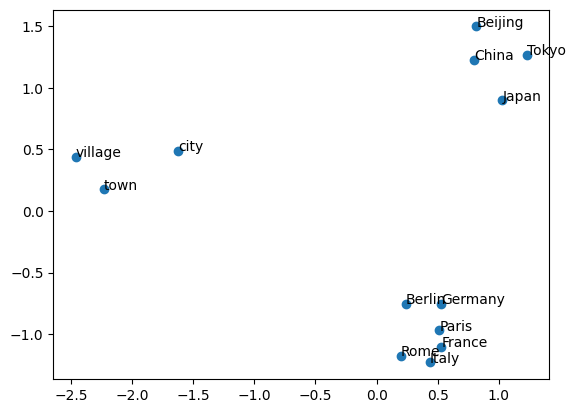

In [32]:
X_reduced = compute_PCA(X, n_components=2)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
for i, word in enumerate(word_list):
    plt.annotate(word, xy=(X_reduced[i, 0], X_reduced[i, 1]))

plt.show()

## 2. CBOW vs Skip-gram

- [Skip-gram]: Predict context words (surrounding words) given target word
- [CBOW]: Predict target word from bag of context words

예를 들어, 다음과 같은 문장이 있다고 하자.

$$ \text{"I am happy because I am learning"} $$

Context size가 2라고 하면

[CBOW]의 경우, target word "happy"를 예측하기 위해 "I", "am", "because", "I"를 이용한다.

반면, [Skip-gram]의 경우, target word "happy"를 통해 "I", "am", "because", "I"를 예측한다.

***

### 2.1 CBOW

CBOW 학습 과정에 대해 자세히 알아보자.

위 예시에서의 경우, CBOW는 다음과 같이 학습된다.

$$ \text{Context = ["I", "am", "because", "I"]} $$
$$ \text{Target = ["happy"]} $$

$$ \text{Input = ["I", "am", "because", "I"]} $$
$$ \text{Output = ["happy"]} $$

이때, 모델 구조는 다음과 같다.

<div style="width:image width px; font-size:100%; text-align:center;"><img src='/content/drive/MyDrive/ai-intensive2/lab3/data/word2.png?raw=1' alt="alternate text" width="width" height="height" style="width:600px;height:250px;" />  </div>

이때, $\bar x$는 input context word들의 one-hot vector의 평균을 의미한다.

$$ \bar x = \frac{1}{4} \sum_{i=1}^{4} x_i $$

최종적으로 정리하자면,

$$ h = W_{1}X + b_1 $$
$$ a = ReLU(h) $$
$$ z = W_{2}a + b_2 $$
$$ \hat y = softmax(z) $$

In [15]:
import nltk
import re
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stopwords = nltk.corpus.stopwords.words('english')
lemm = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [20]:
with open('./data/shakespeare.txt') as f:
    corpus = f.read()

"""
In here, you should implement preprocessing step
1. Replace all non-alphabetic characters with space (you can use regex or isalpha() function either)
2. Replece all punctuations(, ! ? ; -) with period (you should use regex)
3. Tokenize the corpus (you can use nltk.word_tokenize() function)

like..

corpus = re.sub(~~~~)

This preprocessing step is very important to get good performance influencing on after all steps.

"""

corpus = nltk.word_tokenize(corpus)
corpus = [token.lower() for token in corpus]

In [17]:
freq_dist = nltk.FreqDist(word for word in corpus) #Means frequency distribution
print(len(freq_dist))
print(freq_dist.most_common(10))

6432
[(',', 4689), ('.', 3518), ('the', 1520), ('and', 1394), ('i', 1269), ('to', 1159), ('of', 1092), ('my', 857), (';', 782), ('that', 781)]


In [18]:
words = sorted(list(set(corpus)))
idx = 0
word2idx, idx2word = {}, {}
for x in words:
    word2idx[x] = idx
    idx2word[idx] = x
    idx += 1

print(word2idx['apple'])
print(idx2word[0])

vocab_size = len(word2idx)
print(vocab_size)

471
!
6432


### 2.2 Training model

CBOW 모델을 학습시키기 위해, 다음과 같은 과정을 따라간다.

- 1. Model Layer Initialization
- 2. Forward Propagation
- 3. Loss Function
- 4. Backward Propagation
- 5. Gradient Descent

먼저, Model Layer Initialization을 진행한다.

<div style="width:image width px; font-size:100%; text-align:center;"><img src='https://github.com/dh610/ai-intensive2/blob/main/lab3/data/word2.png?raw=1' alt="alternate text" width="width" height="height" style="width:600px;height:250px;" />  </div>

- 첫번째 matrix $W_1$은 $N \times V$의 크기를 가진다.
    * $N$은 word vector의 차원이다.
    * $V$는 vocabulary size이다.


- 두번째 matrix $W_2$는 $V \times N$의 크기를 가진다.
    * $V$는 vocabulary size이다.
    * $N$은 word vector의 차원이다.

<br>

- 첫번째 bias $b_1$은 [BLANK]의 크기를 가진다.
    
- 두번째 bias $b_2$는 [BLANK]의 크기를 가진다.

In [21]:
def init_model(N, V):
    np.random.seed(42)

    W1 = np.random.rand(N, V)
    W2 = np.random.rand(V, N)

    b1 = np.zeros((N, 1))
    b2 = np.zeros((V, 1))

    return W1, W2, b1, b2

Softmax

$$ \text{softmax}(z_i) = \frac{e^{z_i} }{\sum_{i=0}^{V-1} e^{z_i} }  \tag{5} $$

- V는 vocabulary size이다.
- $z_i$는 $i$번째 단어의 score이다.
- i는 0부터 V-1까지의 단어를 의미한다. (idx가 0부터 시작)

In [22]:
def softmax(z):
    e_z = np.exp(z)
    return e_z / np.sum(e_z, axis=0)

### Forward

Forward propagation은 다음과 같이 진행할 수 있다.

$$ h = W_{1}X + b_1 $$
$$ a = ReLU(h) $$
$$ z = W_{2}a + b_2 $$

이때, ReLU function은 다음과 같이 정의된다.

$$ ReLU(x) = \max(0,x) $$

In [33]:
def ReLU(x):
    """
    Implement own ReLU function here
    You can use np library
    """
    return np.maximum(0, x)

In [40]:
def forward(x, W1, W2, b1, b2):
    """
    You should implement forward function that described in the above cell.
    h =
    a =
    z =
    """

    h = np.dot(W1, x) + b1
    a = ReLU(h)
    z = np.dot(W2, a) + b2

    return z, a

### Loss

Cost function은 다음과 같이 cross entropy loss function을 이용한다.

$$ cross\_entropy(y, \hat y) = - \sum_{i=0}^{V-1} [ y_i \log(\hat y_i) + (1-y_i) \log(1-\hat y_i) ]$$

In [39]:
def cross_entropy_loss(y, y_hat, batch_size):
    """
    You should implement cross entropy loss function that described in the above cell. (just one line)
    log_probs =

    I provide you summation part here, with the shape of batch size
    cost = -1/batch_size * np.sum(log_probs)
    cost = np.squeeze(cost) #squeeze is used for removing single-dimensional entries from the shape of an array.
    """

    log_probs = np.multiply(y, np.log(y_hat)) + np.multiply(1 - y, np.log(1 - y_hat))

    cost = -1/batch_size * np.sum(log_probs)
    cost = np.squeeze(cost)

    return cost

### Backpropagation

지금까지 CBOW model이 어떻게 동작하는지 학습했다.
모델을 구조를 Initalize하고, Forward 함수를 정의하였으며, Cost functinon 또한 정의하였다.

이제, Gradient를 계산하여 Back-propagation을 진행하자.

In [36]:
def back_propagation(x, y_hat, y, h, W1, W2, b1, b2, batch_size):
    l1 = np.dot(W2.T, (y_hat - y)) #l1 means layer1
    l1 = ReLU(l1)

    grad_W1 = (1/batch_size) * np.dot(l1, x.T)
    grad_W2 = (1/batch_size) * np.dot(y_hat - y, h.T)

    grad_b1 = np.sum((1/batch_size) * np.dot(l1, x.T), axis=1, keepdims=True)
    grad_b2 = np.sum((1/batch_size) * np.dot(y_hat-y, h.T), axis=1, keepdims=True)

    return grad_W1, grad_W2, grad_b1, grad_b2

In [37]:
"""
!NOTE
This cell provide you just useful functions for training to deal with batch.
You don't need to implement anything in here.
"""

import numpy as np
from collections import defaultdict

def pack_idx_with_frequency(context_words, word2idx):
    freq_dict = defaultdict(int)
    for word in context_words:
        freq_dict[word] += 1
    idxs = get_idx(context_words, word2idx)
    packed = []
    for i in range(len(idxs)):
        idx = idxs[i]
        freq = freq_dict[context_words[i]]
        packed.append((idx, freq))
    return packed

def get_idx(words, word2idx):
    idx = []
    for word in words:
        idx = idx + [word2idx[word]]
    return idx

def get_vectors(data, word2idx, V, C):
    i = C
    while True:
        y = np.zeros(V)
        x = np.zeros(V)
        center_word = data[i]
        y[word2idx[center_word]] = 1
        context_words = data[(i - C):i] + data[(i+1):(i+C+1)]
        num_ctx_words = len(context_words)
        for idx, freq in pack_idx_with_frequency(context_words, word2idx):
            x[idx] = freq/num_ctx_words
        yield x, y
        i += 1
        if i >= len(data):
            print('i is being set to 0')
            i = 0

def get_batches(data, word2idx, V, C, batch_size):
    batch_x = []
    batch_y = []
    for x, y in get_vectors(data, word2idx, V, C):
        while len(batch_x) < batch_size:
            batch_x.append(x)
            batch_y.append(y)
        else:
            yield np.array(batch_x).T, np.array(batch_y).T

def get_dict(data):
    words = sorted(list(set(data)))
    n = len(words)
    idx = 0

    word2idx = {}
    idx2word = {}
    for k in words:
        word2idx[k] = idx
        idx2word[idx] = k
        idx += 1
    return word2idx, idx2word

### Gradient Descent

Backpropagation을 통해 gradient를 계산할 수 있게 되었다.

이제, gradient descent를 통해 parameter를 update할 수 있도록 한다.

그리고 해당 과정을 통해 모델의 학습을 진행하고, loss를 확인한다.

In [43]:
def gradient_descent(data, word2idx, V, N, num_iters, batch_size, window_size):
    iters = 0
    """
    You should implement gradient descent algorithm here.
    You use all of the functions that you have implemented above.

    init model

    for x, y in get_batches(data, word2idx, V, window_size, batch_size):
        z, h =
        y_hat =

        cost =
        if ((iters+1) % 10 == 0): #This line is for printing cost every 10 iterations < DO NOT CHANGE THIS LINE >
            print(f"iters: {iters + 1} cost: {cost:.6f}")

        do back-propagation

        iters += 1
        if iters == num_iters:
            break

    """

    W1, W2, b1, b2 = init_model(N, V)

    for x, y in get_batches(data, word2idx, V, window_size, batch_size):
        z, h = forward(x, W1, W2, b1, b2)
        y_hat = softmax(z)

        cost = cross_entropy_loss(y, y_hat, batch_size)

        if ((iters+1) % 10 == 0): #This line is for printing cost every 10 iterations < DO NOT CHANGE THIS LINE >
            print(f"iters: {iters + 1} cost: {cost:.6f}")

        grad_W1, grad_W2, grad_b1, grad_b2 = back_propagation(x, y_hat, y, h, W1, W2, b1, b2, batch_size)

        W1 -= 0.001 * grad_W1
        W2 -= 0.001 * grad_W2
        b1 -= 0.01 * grad_b1
        b2 -= 0.01 * grad_b2

        iters += 1
        if iters == num_iters:
            break

    return W1, W2, b1, b2

In [44]:
word2idx, idx2word = get_dict(corpus)

W1, W2, b1, b2 = gradient_descent(corpus, word2idx, len(word2idx), N=50, num_iters=300,  batch_size=128, window_size=2)

iters: 10 cost: 8.461147
iters: 20 cost: 5.657198
iters: 30 cost: 3.055674
iters: 40 cost: 1.280919
iters: 50 cost: 0.619907
iters: 60 cost: 0.380475
iters: 70 cost: 0.268756
iters: 80 cost: 0.206092
iters: 90 cost: 0.166505
iters: 100 cost: 0.139402
iters: 110 cost: 0.119753
iters: 120 cost: 0.104885
iters: 130 cost: 0.093259
iters: 140 cost: 0.083928
iters: 150 cost: 0.076279
iters: 160 cost: 0.069897
iters: 170 cost: 0.064494
iters: 180 cost: 0.059861
iters: 190 cost: 0.055846
iters: 200 cost: 0.052334
iters: 210 cost: 0.049236
iters: 220 cost: 0.046483
iters: 230 cost: 0.044021
iters: 240 cost: 0.041806
iters: 250 cost: 0.039803
iters: 260 cost: 0.037982
iters: 270 cost: 0.036321
iters: 280 cost: 0.034799
iters: 290 cost: 0.033400
iters: 300 cost: 0.032108
